In [1]:
import matplotlib.tri as tri
from matplotlib.collections import PolyCollection
from scipy.interpolate import griddata

import meshio
import gmsh
import sys
from dolfin import *
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
import os
import time

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Smart Adaptive  MESH

In [4]:

class FiberCompositeMeshGenerator:
    def __init__(self, L=1.0, R_input=0.035, lc=0.03, n_fibers_x=10, n_fibers_y=10, wall_gap=0.005, target_vol_frac=None):
        self.L = L #   meter Domain size
        self.R_input = R_input ## Fiber radius  
        self.lc = lc # Mesh resolution (Balance between accuracy and condition number)
        self.n_fibers_x = n_fibers_x # Manual number of fibers in x direction
        self.n_fibers_y = n_fibers_y # Manual number of fibers in y direction
        self.wall_gap = wall_gap # Gap between fibers and wall to avoid overlap
        
        if target_vol_frac is not None:

            # Calculate Area of one fiber
            fiber_area = np.pi * (R_input ** 2)
            
            # Calculate Total Required Area
            total_required_area = (L**2) * target_vol_frac
            
            # Calculate Total Count needed
            n_total = total_required_area / fiber_area
            
            # Calculate Grid Side (Square Root) and Round to nearest integer
            # This overwrites the inputs n_fibers_x and n_fibers_y
            grid_side = int(round(np.sqrt(n_total))) # number of fibers along one side of the square domain
            
            # Safety: Ensure at least 1 fiber
            if grid_side < 1: grid_side = 1
            
            self.n_fibers_x = grid_side
            self.n_fibers_y = grid_side
            
            # Print info for user verification
            actual_vf = (grid_side**2 * fiber_area) / (L**2)
            print(f"--- AUTO MODE: Volume Fraction ---")
            print(f"Requested VF: {target_vol_frac*100:.2f}%")
            print(f"Calculated Grid: {self.n_fibers_x} x {self.n_fibers_y} ({self.n_fibers_x**2} fibers)")
            print(f"Resulting VF: {actual_vf*100:.2f}%") #Print actual volume fraction achieved since rounding of fiber is done  
            
        else:
            # --- MODE B: MANUAL (Grid Input) ---
            # Just use the values passed in init arguments
            self.n_fibers_x = n_fibers_x
            self.n_fibers_y = n_fibers_y
            print(f"--- MANUAL MODE: Grid Input ---")
            print(f"Using Grid: {self.n_fibers_x} x {self.n_fibers_y}")

    def generate(self):

        gmsh.initialize()
        gmsh.model.add("Fiber_Composite")

        

           
        occ = gmsh.model.occ
        
        # Safety Calculation ---
        start_point = self.R_input + self.wall_gap
        usable_span = self.L - 2 * (self.R_input + self.wall_gap)
        step_size = usable_span / (self.n_fibers_x - 1)
        #2R<spacing to avoid overlap of fibers
        R = self.R_input
        if step_size < 2 * R:
            R = step_size * 0.45
            print(f"Safety Override: Radius shrunk to {R:.4f}")

        # Calculate max allowable radius to prevent touching each other or the wall
        # R must be less than spacing/2

        # Create Geometry
        square = occ.addRectangle(0, 0, 0, self.L, self.L) #Rectangle(x, y, z, width, height)
        # Create multiple fibers in a grid pattern
        fiber_list = []
    # Generate Grid (Vectorized is cleaner)
        x_coords = np.linspace(start_point, self.L-start_point, self.n_fibers_x)
        y_coords = np.linspace(start_point, self.L-start_point, self.n_fibers_y)

        for x in x_coords:
            for y in y_coords:
                c = occ.addDisk(x, y, 0, R, R)
                fiber_list.append((2, c))

        #  Fragment and Synchronize
        #  ov contains all resulting surfaces after the boolean operation
        
        ov, ovv = occ.fragment([(2, square)], fiber_list) #Fragment the square with the circle {dim, tag}. Note ovv are separate entities
        occ.synchronize()

        # Dynamically Identify Surfaces
        # Attention: The problem is that after the fragmenting.Gmsh doesn't inherently know which ID belongs to the "Matrix" and which belongs to the "Fiber." It just sees two surfaces.
        # We look for the surface whose center of mass is the center of the square. # 

        fiber_surface = []
        matrix_surface = []

        for surface in gmsh.model.getEntities(2):
            # Get mass properties (this returns [mass/area, x, y, z])
            # For a 2D surface, 'mass' is actually the area.
            mass_center = occ.getCenterOfMass(surface[0], surface[1])
                                    
            # We use a tool to get the actual area
            # (Dimension 2, ID surface[1])
            mass_props = occ.getMass(surface[0], surface[1])
            area = mass_props # Area is the first element returned 

            # Logic: If it's small, it's the fiber. If it's large, it's the matrix.
            expected_fiber_area = 3.14159 * (R**2)
                                        
            if abs(area - expected_fiber_area) < 1e-4:
                fiber_surface.append(surface[1])
                print(f"Surface {surface[1]} identified as FIBER (Area: {area:.4f})")
            else:
                matrix_surface.append(surface[1])
                print(f"Surface {surface[1]} identified as MATRIX (Area: {area:.4f})")

        # Now we have the IDs for both surfaces.
        #Assign Physical Groups for Material Domains to help solver recognize them
        gmsh.model.addPhysicalGroup(2, fiber_surface, tag=1, name="Fiber_Domain")
        gmsh.model.addPhysicalGroup(2, matrix_surface, tag=2, name="Matrix_Domain")

        # label the Top and Bottom edges for a thermal gradient
        # Identify and Tag Boundary Edges ---
        left_edges = []
        right_edges = []
        top_edges = []
        bottom_edges = []
        fiber_interface = []
        # Get all 1D entities (curves/lines)
        for edge in gmsh.model.getEntities(1):
            # Get the bounding box of the line [xmin, ymin, zmin, xmax, ymax, zmax]
            bounds = gmsh.model.getBoundingBox(edge[0], edge[1])
            # Unpack bounds  
            xmin, ymin, xmax, ymax = bounds[0], bounds[1], bounds[3], bounds[4] #[xmin, ymin, zmin, xmax, ymax, zmax]

            # Check position with a small tolerance (1e-6)
            if abs(xmin) < 1e-6 and abs(xmax) < 1e-6:
                left_edges.append(edge[1])                       #append edge ID to left_edges
            elif abs(xmin - self.L) < 1e-6 and abs(xmax - self.L) < 1e-6:
                right_edges.append(edge[1])                      #append edge ID to right_edges
            elif abs(ymin) < 1e-6 and abs(ymax) < 1e-6:
                bottom_edges.append(edge[1])                     #append edge ID to bottom_edges
            elif abs(ymin - self.L) < 1e-6 and abs(ymax - self.L) < 1e-6:
                top_edges.append(edge[1])                        #append edge ID to top_edges
            else:
                # If it's not an outer wall, it's the interface between fiber and matrix!
                fiber_interface.append(edge[1])

        # Create Physical Group for the interface (Tag 20)
        gmsh.model.addPhysicalGroup(1, fiber_interface, tag=20, name="Fiber_Interface")
        # Create Physical Groups for the boundaries
        gmsh.model.addPhysicalGroup(1, left_edges, tag=10, name="Left_Side") ## (dimension, list_of_ids, tag, name)
        gmsh.model.addPhysicalGroup(1, right_edges, tag=11, name="Right_Side")
        gmsh.model.addPhysicalGroup(1, top_edges, tag=12, name="Top_Side")
        gmsh.model.addPhysicalGroup(1, bottom_edges, tag=13, name="Bottom_Side")

        # gmsh.model.mesh.setSize(gmsh.model.getEntities(0), lc) #Set mesh size at all vertices (0D entities) smaller lc = finer mesh(so its saying keep the distance between any two triangles at corner points of geometry  smaller in other words make the mesh smaller)
        # gmsh.model.mesh.generate(2) #Generate 2D mesh 2 is dimension

        # Local Mesh Refinement (Fields) ---

        # FIELD 1: Distance - Calculates distance from every point to the fiber edges
        f1 = gmsh.model.mesh.field.add("Distance")
        gmsh.model.mesh.field.setNumbers(f1, "CurvesList", fiber_interface)

        # FIELD 2: Threshold - Takes the distance and maps it to a mesh size
        f2 = gmsh.model.mesh.field.add("Threshold")
        gmsh.model.mesh.field.setNumber(f2, "InField", f1)      # Use the distance field as input
        gmsh.model.mesh.field.setNumber(f2, "SizeMin", self.lc / 6)  # Mesh size AT the fiber edge (tiny;closer to fiber)
        gmsh.model.mesh.field.setNumber(f2, "SizeMax", self.lc)      # Mesh size in the matrix (normal)
        gmsh.model.mesh.field.setNumber(f2, "DistMin", self.R_input*0.30)    # Range for SizeMin (all points equal/ closer than this distance get SizeMin)
        gmsh.model.mesh.field.setNumber(f2, "DistMax", self.R_input*0.31)    # Distance where it reaches SizeMax (all points farther than this distance get SizeMax)

        # FIELD 3: Constant - This ensures the mesh stays small INSIDE the fiber surfaces
        f3 = gmsh.model.mesh.field.add("Constant") 
        gmsh.model.mesh.field.setNumbers(f3, "SurfacesList", fiber_surface) #F3 returns default mesh value if point is outside fibers 
        gmsh.model.mesh.field.setNumber(f3, "VIn", self.lc / 6)      # Force this size inside the fibers

        # FIELD 4: Min - Combines f2 (matrix transition) and f3 (fiber interior)
        # It tells Gmsh: "At any point, use the SMALLEST size from either Field 2 or Field 3"
        f_min = gmsh.model.mesh.field.add("Min")
        gmsh.model.mesh.field.setNumbers(f_min, "FieldsList", [f2, f3])

        # Activate the refinement using the combined logic
        gmsh.model.mesh.field.setAsBackgroundMesh(f_min) #this combines both fields so that we have fine mesh near fiber edges and also fine mesh inside fibers. Check f2 and f3 for details. 

        # Disable default settings that may override our fields
        gmsh.option.setNumber("Mesh.MeshSizeFromPoints", 0)
        gmsh.option.setNumber("Mesh.MeshSizeFromCurvature", 0)
        gmsh.option.setNumber("Mesh.MeshSizeExtendFromBoundary", 0)

        # Generate  
        gmsh.model.mesh.generate(2)
        gmsh.write("refined_composite_with_interior.msh")

        if '-nopopup' not in sys.argv:
            gmsh.fltk.run()

        gmsh.finalize()

# Main Mesh Generator

In [5]:
L=1.0  # Domain size in meters
R_input=0.035  # Initial fiber radius in meters
lc=0.01  # Mesh resolution
n_fibers_x=10  # Number of fibers in x direction
n_fibers_y=10  # Number of fibers in y direction
wall_gap=0.005  # Gap between fibers and wall to avoid overlap
target_vol_frac= 0.4  # Target volume fraction (set to None for manual fibers )
MeshGenerator = FiberCompositeMeshGenerator(L=L, R_input=R_input, lc=lc, n_fibers_x=n_fibers_x, n_fibers_y=n_fibers_y, wall_gap=wall_gap, target_vol_frac=target_vol_frac) 
MeshGenerator.generate()

--- AUTO MODE: Volume Fraction ---
Requested VF: 40.00%
Calculated Grid: 10 x 10 (100 fibers)
Resulting VF: 38.48%
Surface 2 identified as FIBER (Area: 0.0038)                                                                                                  
Surface 3 identified as FIBER (Area: 0.0038)
Surface 4 identified as FIBER (Area: 0.0038)
Surface 5 identified as FIBER (Area: 0.0038)
Surface 6 identified as FIBER (Area: 0.0038)
Surface 7 identified as FIBER (Area: 0.0038)
Surface 8 identified as FIBER (Area: 0.0038)
Surface 9 identified as FIBER (Area: 0.0038)
Surface 10 identified as FIBER (Area: 0.0038)
Surface 11 identified as FIBER (Area: 0.0038)
Surface 12 identified as FIBER (Area: 0.0038)
Surface 13 identified as FIBER (Area: 0.0038)
Surface 14 identified as FIBER (Area: 0.0038)
Surface 15 identified as FIBER (Area: 0.0038)
Surface 16 identified as FIBER (Area: 0.0038)
Surface 17 identified as FIBER (Area: 0.0038)
Surface 18 identified as FIBER (Area: 0.0038)
Surface 19 id

# Converting File for Feneics

In [6]:

 

# Read mesh
msh = meshio.read("refined_composite_with_interior.msh")
points = msh.points[:, :2]  # 2D

# --- Mesh (geometry) ---
triangles = msh.cells_dict["triangle"]
meshio.write("mesh.xdmf", meshio.Mesh(points=points, cells={"triangle": triangles}))

# --- Cell markers (subdomains) ---
cell_data = msh.cell_data_dict["gmsh:physical"]["triangle"]
meshio.write(
    "subdomains.xdmf",
    meshio.Mesh(points=points, cells={"triangle": triangles}, cell_data={"subdomains": [cell_data]})
)

# --- Facet markers (boundaries) ---
if "line" in msh.cells_dict:
    lines = msh.cells_dict["line"]
    facet_data = msh.cell_data_dict["gmsh:physical"]["line"] #nested dictionary 
    meshio.write(
        "boundaries.xdmf",
        meshio.Mesh(points=points, cells={"line": lines}, cell_data={"boundaries": [facet_data]}) 
    )
else:
    print("No boundary lines found.")

# Solver for Homogenization

In [7]:
import time
import numpy as np
import matplotlib.pyplot as plt
from dolfin import *

class HomogeneousCompositeSolver:
    def __init__(self, theta=10, k_m=1.0, k_par=100.0, k_perp=5.0):
        self.theta = theta
        self.k_m = k_m
        self.k_par = k_par
        self.k_perp = k_perp
        # Storage for benchmark data: {label: (time, success_status)}
        self.performance_data = {}

    def solve(self):
        # Parameters
        theta = np.deg2rad(self.theta)
        k_m = self.k_m
        
        # Rotated fiber conductivity components
        c, s = np.cos(theta), np.sin(theta)
        K_f_xx = self.k_par * c**2 + self.k_perp * s**2
        K_f_xy = (self.k_par - self.k_perp) * c * s
        K_f_yy = self.k_par * s**2 + self.k_perp * c**2

        # Load mesh
        mesh = Mesh()
        with XDMFFile("mesh.xdmf") as f:
            f.read(mesh)
        mvc = MeshValueCollection("size_t", mesh, 2)
        with XDMFFile("subdomains.xdmf") as f:
            f.read(mvc, "subdomains")
        cell_markers = MeshFunction("size_t", mesh, mvc)

        class KTensor(UserExpression):
            def __init__(self, markers, **kwargs):
                super().__init__(**kwargs)
                self.markers = markers
            def eval_cell(self, values, x, cell):
                if self.markers[cell.index] == 1:
                    values[0] = K_f_xx; values[1] = K_f_xy
                    values[2] = K_f_xy; values[3] = K_f_yy
                else:
                    values[0] = k_m; values[1] = 0.0
                    values[2] = 0.0; values[3] = k_m
            def value_shape(self):
                return (2, 2)

        K = KTensor(cell_markers, degree=0)
        V = FunctionSpace(mesh, "CG", 2)
        dx_measure = Measure('dx', domain=mesh)
          
        def solve_with_bcs(bcs, solver_type="cg", pc_type="hypre_amg", label=None):
            u = TrialFunction(V); v = TestFunction(V)
            a = inner(K * grad(u), grad(v)) * dx_measure 
            L = Constant(0.0) * v * dx_measure 
            u_sol = Function(V)
            
            start_t = time.perf_counter()
            success = True
            
            try:
                # error_on_nonconvergence must be True to trigger the 'except' block
                solve(a == L, u_sol, bcs, solver_parameters={
                    "linear_solver": solver_type, 
                    "preconditioner": pc_type,
                    "krylov_solver": {
                        "relative_tolerance": 1e-6,
                        "maximum_iterations": 1000,
                        "error_on_nonconvergence": True 
                    }
                })
            except RuntimeError:
                success = False
            
            end_t = time.perf_counter()
            duration = end_t - start_t
            
            if label:
                self.performance_data[label] = (duration, success)
            return u_sol

        # Setup Boundaries
        bc_left = DirichletBC(V, Constant(0.0), "on_boundary && near(x[0], 0.0)")
        bc_right = DirichletBC(V, Constant(1.0), "on_boundary && near(x[0], 1.0)")

        # Benchmarking
        u1_gaussian = solve_with_bcs([bc_left, bc_right], "lu", "none", "Gaussian")
        u1_amg      = solve_with_bcs([bc_left, bc_right], "cg", "hypre_amg", "AMG")
        u1_jacobi   = solve_with_bcs([bc_left, bc_right], "richardson", "jacobi", "Rich-Jacobi")
        u1_sidel    = solve_with_bcs([bc_left, bc_right], "richardson", "sor", "Rich-Gauss-Seidel")
        
        u1 = u1_amg # Use converged result for calculations

        bc_bottom = DirichletBC(V, Constant(0.0), "on_boundary && near(x[1], 0.0)")
        bc_top = DirichletBC(V, Constant(1.0), "on_boundary && near(x[1], 1.0)")
        u2 = solve_with_bcs([bc_bottom, bc_top]) 

        # Corrected Plotting Logic
        plt.figure(figsize=(10, 6))
        names = list(self.performance_data.keys())
        times = [val[0] for val in self.performance_data.values()]
        # Status mapping for bar colors
        colors = ['green' if val[1] else 'red' for val in self.performance_data.values()]
        
        plt.bar(names, times, color=colors)
        plt.ylabel('Execution Time (s)')
        plt.title('Solver Benchmarking: Convergence Success (Green) vs. Failure (Red)')
        
        for i, v in enumerate(times):
            plt.text(i, v, f" {v:.4f}s", va='bottom', ha='center', fontweight='bold')
        plt.show()

        # Compute K_eff
        dx = Measure('dx', domain=mesh)
        area = assemble(Constant(1.0) * dx)
        q1 = -K * grad(u1); q2 = -K * grad(u2)
        
        K_eff = np.array([
            [-assemble(q1[0]*dx)/area, -assemble(q2[0]*dx)/area],
            [-assemble(q1[1]*dx)/area, -assemble(q2[1]*dx)/area]
        ])
        
        # Symmetry correction
        K_eff = np.array([
            [ K_eff[0,0], (K_eff[0,1] + K_eff[1,0])/2 ],
            [ (K_eff[1,0] + K_eff[0,1])/2, K_eff[1,1] ]
        ])
        
        return K_eff, cell_markers, u1, u2

# Main For Homogenization

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
  Solving linear variational problem.
  Solving linear variational problem.


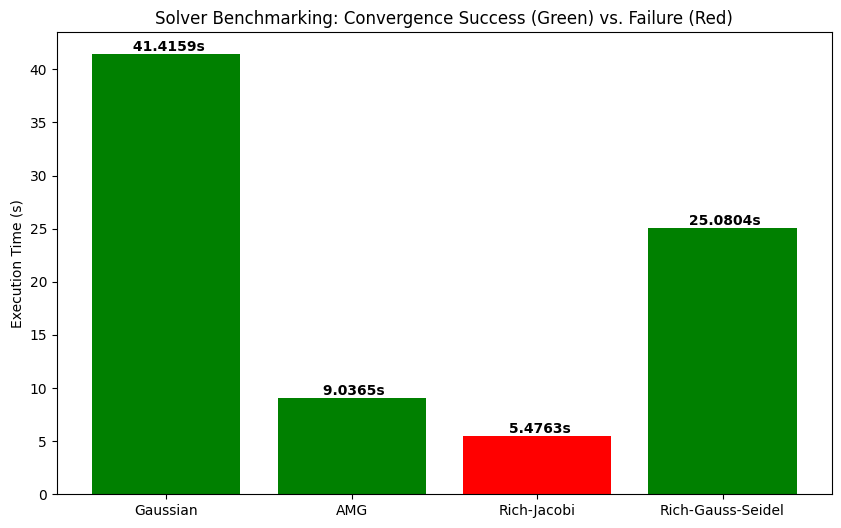

In [8]:
#Parameters
theta=10 #tilted fiber in geiometry 
k_m=1.0 
k_par=100.0 
k_perp=5.0
runner= HomogeneousCompositeSolver(theta=theta, k_m= k_m, k_par= k_par, k_perp=k_perp)
K_eff_result, cell_markers,u1,u2=runner.solve()

In [7]:
results = []
angles = np.arange(0, 100, 10)

for a in angles:
    solver = HomogeneousCompositeSolver(theta=a)
    K_eff_matrix,dummy1,dummy2,dummy3= solver.solve() # Ensure your solve() returns K_eff. Also dummy variables to ignore other returns
    results.append(K_eff_matrix)

# To plot Keff components vs angle
k_xy_values = [m[0, 1] for m in results]
k_xx_values=  [m[0, 0] for m in results]
k_yy_values=  [m[1, 1] for m in results]


# Create the plots
plt.figure(figsize=(10, 6))

plt.plot(angles, k_xx_values, 'r-o', label='$K_{xx}$ (Horizontal)')
plt.plot(angles, k_yy_values, 'b-s', label='$K_{yy}$ (Vertical)')
plt.plot(angles, k_xy_values, 'g-d', label='$K_{xy}$ (Shear/Steering)')

plt.yscale('log')
plt.title("Effective Conductivity vs. Fiber Angle")
plt.xlabel("Fiber Angle $\\theta$ (Degrees)")
plt.ylabel("Conductivity Value")
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

  Solving linear variational problem.
  Solving linear variational problem.
  Solving linear variational problem.
    Solving linear variational problem.
    Solving linear variational problem.


KeyboardInterrupt: 

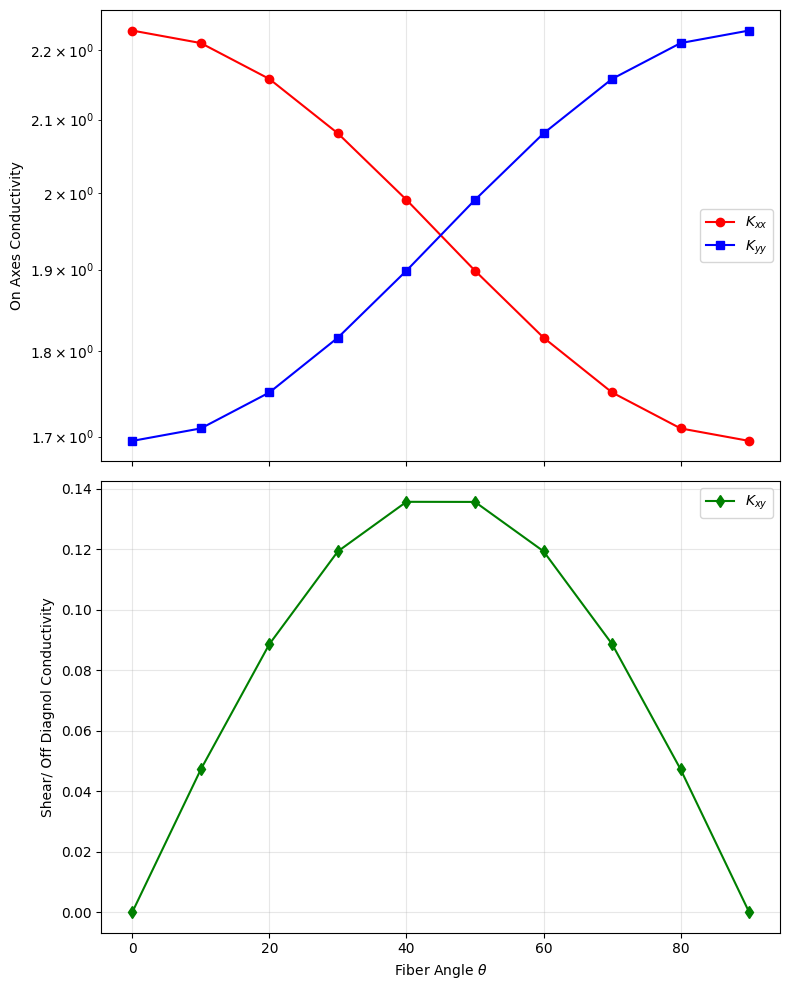

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# Top Plot: Primary Components
ax1.plot(angles, k_xx_values, 'r-o', label='$K_{xx}$')
ax1.plot(angles, k_yy_values, 'b-s', label='$K_{yy}$')
ax1.set_yscale('log')
ax1.set_ylabel('On Axes Conductivity')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom Plot: The Coupling/Shear Term
ax2.plot(angles, k_xy_values, 'g-d', label='$K_{xy}$')
ax2.set_xlabel('Fiber Angle $\\theta$')
ax2.set_ylabel('Shear/ Off Diagnol Conductivity')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Saving Data for angles

In [ ]:



# Use a simple filename without a path
filename = "composite_data.npz"

try:
    # Check if variables exist first
    # We use np.array() to ensure they are in a format numpy likes
    np.savez(filename, 
             angles=np.array(angles), 
             k_xx=np.array(k_xx_values), 
             k_xy=np.array(k_xy_values), 
             k_yy=np.array(k_yy_values))
    
    if os.path.exists(filename):
        print(f" SUCCESS! File saved at: {os.path.abspath(filename)}")
    else:
        print(" File not found after save attempt.")
except Exception as e:
    print(f" ERROR: {e}")

 SUCCESS! File saved at: /mnt/c/Users/Uzair Safi/AppData/Local/Programs/Microsoft VS Code/composite_data.npz


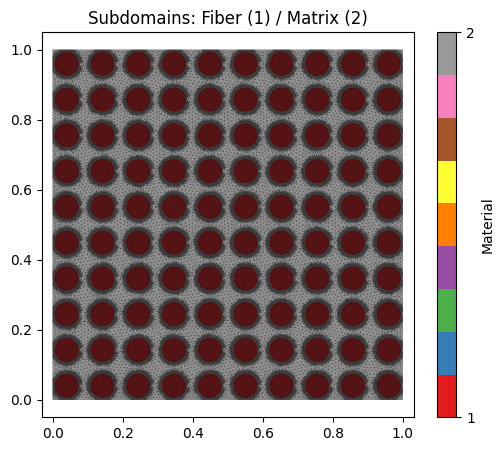

In [ ]:
# Get cell markers as array
 

cell_values = cell_markers.array()

plt.figure(figsize=(6, 5))
plt.tripcolor(points[:, 0], points[:, 1], triangles, 
              facecolors=cell_values, 
              cmap="Set1", 
              edgecolors='k', 
              linewidth=0.1)
plt.title("Subdomains: Fiber (1) / Matrix (2)")
plt.axis("equal")
plt.colorbar(ticks=[1, 2], label="Material")
plt.show()

In [ ]:

import os
os.makedirs("results", exist_ok=True)
# Save as .pvd (FEniCS 2019 compatible)
File("results/u1.pvd") << u1 #[create folder results with u1 and u2 files :"<<"" means to write to file]
File("results/u2.pvd") << u2
File("results/subdomains.pvd") << cell_markers

 

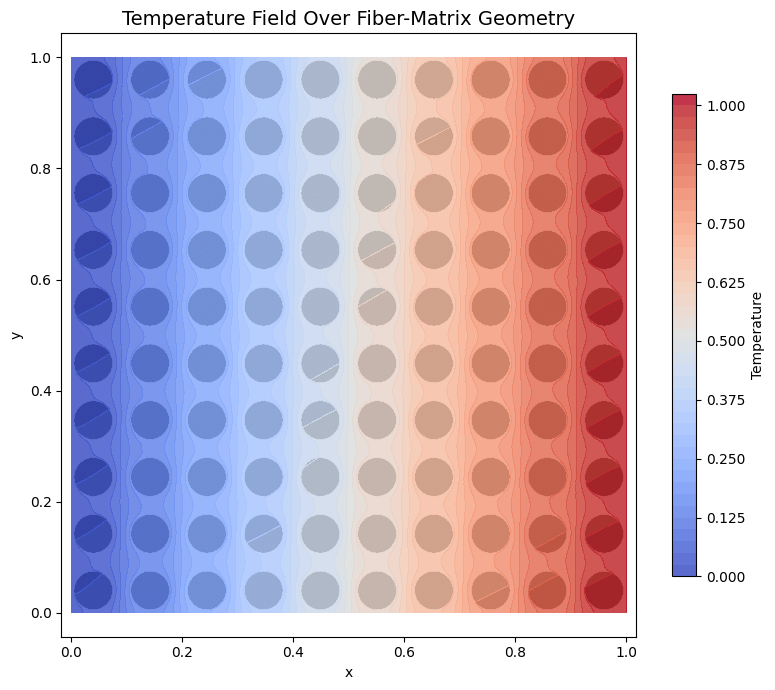

In [ ]:
 # Temperature Gradient

plt.figure(figsize=(8, 7))

#Plot geometry (fibers = white/gray, matrix = dark) — faint background
plot(cell_markers, cmap="gray", alpha=0.4, zorder=1)

# Overlay temperature field (semi-transparent so geometry shows through)
pp = plot(u1, cmap="coolwarm", alpha=0.85, zorder=2)

plt.colorbar(pp, label="Temperature", shrink=0.8)
plt.title("Temperature Field Over Fiber-Matrix Geometry", fontsize=14)
plt.xlabel("x"); plt.ylabel("y")
plt.axis("equal")
plt.tight_layout()
plt.show()

In [25]:


solver_pairs = [
    ("cg", "hypre_amg"),
    ("richardson", "jacobi")
]

print(f"{'Solver Type':<25} | {'rtol':<10} | {'atol':<10} | {'max_it':<10}")
print("-" * 65)

for s_type, p_type in solver_pairs:
    # Initialize the solver
    solver = PETScKrylovSolver(s_type, p_type)
    
    # Get the PETSc KSP object
    ksp = solver.ksp()
    
    # Extract the tolerances
    rtol, atol, dtol, max_it = ksp.getTolerances()
    
    # Print in a formatted row
    label = f"{s_type}/{p_type}"
    print(f"{label:<25} | {rtol:<10} | {atol:<10} | {max_it:<10}")

Solver Type               | rtol       | atol       | max_it    
-----------------------------------------------------------------
cg/hypre_amg              | 1e-05      | 1e-50      | 10000     
richardson/jacobi         | 1e-05      | 1e-50      | 10000     


In [2]:
import dolfin
print(dolfin.__version__)

2019.2.0.64.dev0
